In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/traffic-sign-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0004 - Copy - Copy.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0004 - Copy.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0004.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005 - Copy (2) - Copy.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005 - Copy (2).png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005 - Copy (3).png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005 - Copy - Copy.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005 - Copy.png  
  inflating: traffic-sign-dataset/Traffic_Data/Data/41/041_0005.png  
 extracting: traffic-sign-dataset/Traffic_Data/Data/41/041_0005_j - Copy (2) - Copy.png  
 extracting: traffic-sign-dataset/Traffic_Data/Data/41/041_0005_j - Copy (2).png  
 extracting: traffic-sign-dataset/Traffic_Data/Data/41/041_0005_

##Importing the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import random
from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import MobileNet, resnet50, InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sns.set_style('whitegrid')
sns.set()
%matplotlib inline

##Loading and Analyzing Traffic Sign Class Labels

In [ ]:
df= pd.read_csv('/content/traffic-sign-dataset/class_labels.csv')

In [ ]:
df2= pd.read_csv('/content/drive/MyDrive/class_labels_ml.csv')

In [ ]:
d=df['Name'].unique()
len(d)

55

##Collecting Image Paths and Labels for Traffic Sign Dataset

In [ ]:
data_dir = "/content/traffic-sign-dataset/Traffic_Data/Data"

image_paths = []
labels = []

classes = os.listdir(data_dir)
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    files = os.listdir(class_dir)

    for file in files:
        image_paths.append(os.path.join(class_dir, file))
        labels.append(class_name)

##Preprocessing and Feature Extraction with HOG (Histogram of Oriented Gradients)

In [ ]:
max_feature_length = 0
features = []
for path in image_paths:
    image = imread(path, as_gray=True)
    image = rescale(image, 0.6)
    feature_vector = hog(image)
    features.append(feature_vector)
    max_feature_length = max(max_feature_length, len(feature_vector))


desired_feature_length = 4000
for i in range(len(features)):
    feature_vector = features[i]
    if len(feature_vector) > desired_feature_length:
        feature_vector = feature_vector[:desired_feature_length]
    elif len(feature_vector) < desired_feature_length:
        feature_vector = np.resize(feature_vector, desired_feature_length)
    features[i] = feature_vector

# **Deep Learning**

##Data Splitting for Training and Validation Sets

In [ ]:
def split_data(data_dir, save_dir, train_ratio,valid_ratio):
    train_dir = os.path.join(save_dir, 'train')
    valid_dir = os.path.join(save_dir, 'valid')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        train_class_dir = os.path.join(train_dir, class_name)
        valid_class_dir = os.path.join(valid_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(valid_class_dir, exist_ok=True)

        files = os.listdir(class_dir)
        random.shuffle(files)

        total_files = len(files)
        train_split = int(train_ratio * total_files)
        train_files = files[:train_split]
        valid_files = files[train_split:]

        for file in train_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(train_class_dir, file)
            shutil.copyfile(src, dst)

        for file in valid_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(valid_class_dir, file)
            shutil.copyfile(src, dst)

    print("Data split into train, valid, and test directories.")
data_dir = "/content/traffic-sign-dataset/Traffic_Data/Data"
save_dir = "/content/split_data"

train_ratio = 0.85
valid_ratio = 0.15
split_data(data_dir, save_dir, train_ratio, valid_ratio)

Data split into train, valid, and test directories.


##Image Data Augmentation and Training Set Generation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10)
training_set = train_datagen.flow_from_directory('/content/split_data/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
training_set.class_indices

Found 6846 images belonging to 58 classes.


{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '50': 46,
 '51': 47,
 '52': 48,
 '53': 49,
 '54': 50,
 '55': 51,
 '56': 52,
 '57': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57}

##Validation Set Generation

In [ ]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_set = validation_datagen.flow_from_directory('/content/split_data/valid',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
validation_set.class_indices

Found 1233 images belonging to 58 classes.


{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '50': 46,
 '51': 47,
 '52': 48,
 '53': 49,
 '54': 50,
 '55': 51,
 '56': 52,
 '57': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57}

##Displaying Sample Images with Labels from the Training Set

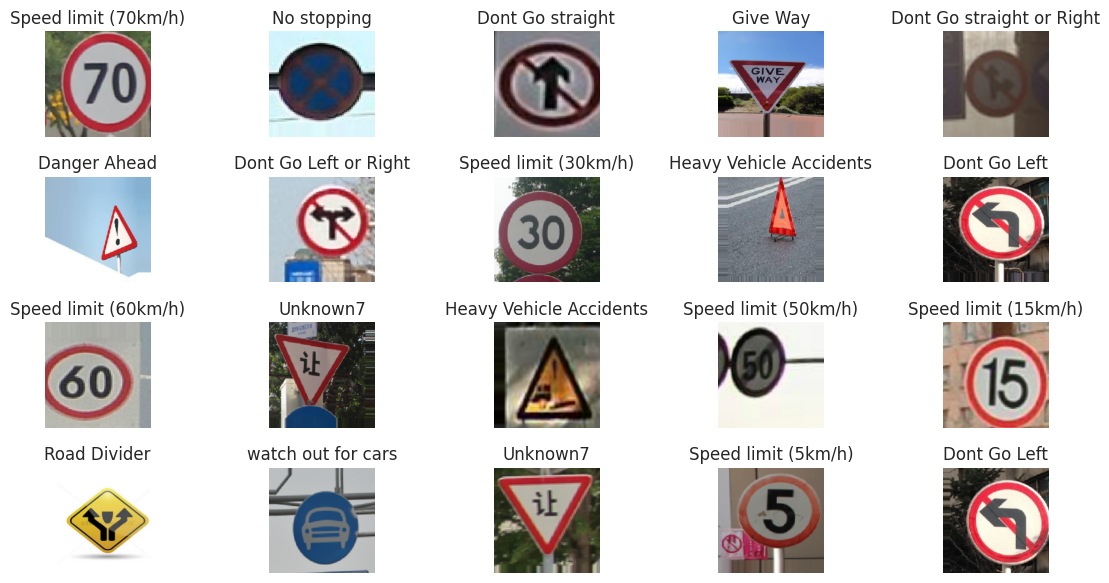

In [ ]:
t_img , label = training_set.next()

def plotImages(img_arr, labels, df):
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 6))
    count = 0
    for row in axs:
        for ax in row:
            ax.imshow(img_arr[count])
            class_id = np.argmax(labels[count])
            filtered_df = df[df['ClassId'] == class_id]
            label_name = filtered_df['Name'].values[0]
            ax.set_title(label_name)
            ax.axis('off')
            count += 1
            if count == 20:
                break
        if count == 20:
            break
    plt.tight_layout()
    plt.show()


plotImages(t_img, label,df)

##Transfer Learning with InceptionV3 for Image Classification

In [ ]:
base_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
x = base_model.output
x= Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x= Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(58, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

##Model Training and Evaluation

In [ ]:
import time
start_time = time.time()
history=model.fit(training_set, validation_data=validation_set, epochs = 30)
end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))

Epoch 1/30
214/214 [==============================] - 177s 563ms/step - loss: 1.6169 - accuracy: 0.5874 - val_loss: 4.9603 - val_accuracy: 0.2052
Epoch 2/30
214/214 [==============================] - 111s 520ms/step - loss: 0.5140 - accuracy: 0.8592 - val_loss: 1.0755 - val_accuracy: 0.7648
Epoch 3/30
214/214 [==============================] - 113s 525ms/step - loss: 0.3416 - accuracy: 0.9084 - val_loss: 0.8474 - val_accuracy: 0.8362
Epoch 4/30
214/214 [==============================] - 114s 532ms/step - loss: 0.2709 - accuracy: 0.9280 - val_loss: 0.4703 - val_accuracy: 0.8962
Epoch 5/30
214/214 [==============================] - 112s 524ms/step - loss: 0.1840 - accuracy: 0.9498 - val_loss: 0.4987 - val_accuracy: 0.8759
Epoch 6/30
214/214 [==============================] - 117s 546ms/step - loss: 0.1453 - accuracy: 0.9573 - val_loss: 0.4906 - val_accuracy: 0.8824
Epoch 7/30
214/214 [==============================] - 114s 531ms/step - loss: 0.1368 - accuracy: 0.9630 - val_loss: 0.1853 -

In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/traffic_inception.h5")

##Plotting Training and Validation Accuracy/Loss

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

NameError: ignored

##Visualization of Activation Maps for a Specific Layer in an Image

1/1 [==============================] - 0s 256ms/step


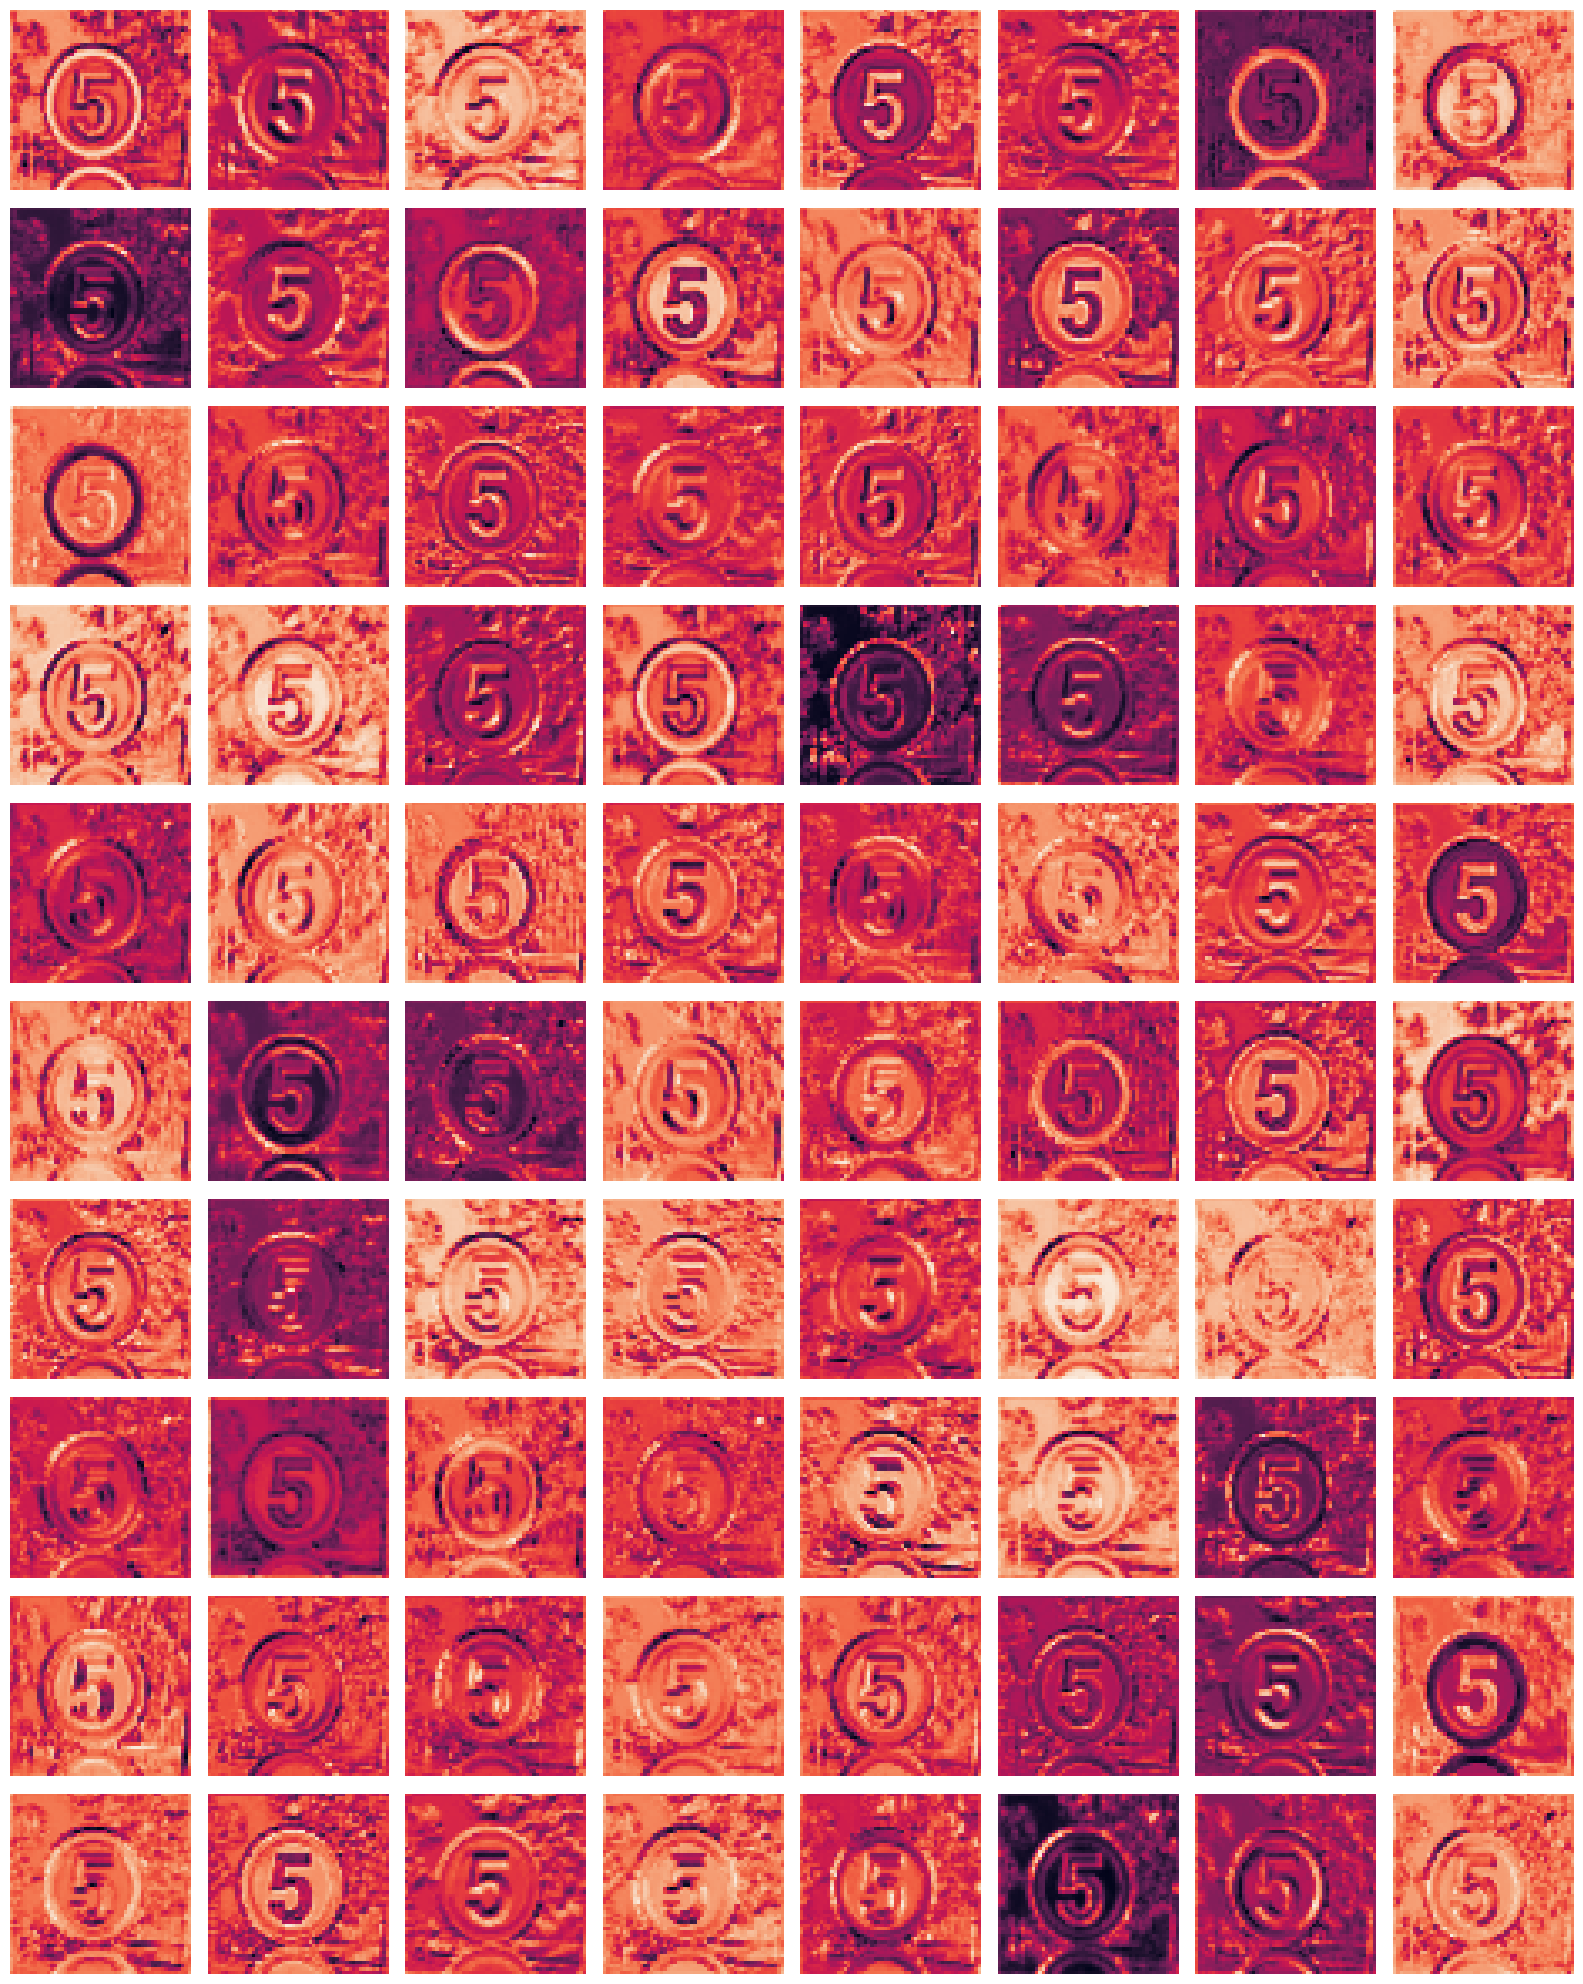

In [ ]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_3'
img_path = '/content/traffic-sign-dataset/Traffic_Data/Test/000_0003_j.png'

visualize_activation_maps(model, img_path, layer_name)

##Evaluating Model Performance on Training and Validation Sets

In [ ]:

train = model.evaluate(training_set)
valid = model.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])

39/39 [==============================] - 6s 139ms/step - loss: 0.0201 - accuracy: 0.9943
                                        
                                        
Train Loss:  0.026105528697371483
Train Accuracy:  0.9893368482589722
                                        
                                        
Validation Loss:  0.02005806751549244
Validation Accuracy:  0.9943227767944336


##Image Prediction and Visualization

In [ ]:
import time
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/DL Model/traffic_inception.h5")
img = cv2.imread('/content/traffic-sign-dataset/Traffic_Data/Test/000_0001_j.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.resize(gray, (224, 224))
gray = gray / 255.0

In [ ]:

start_time = time.time()

pred = model.predict(np.expand_dims(gray, axis=0), verbose=False)[0].argmax()
end_time = time.time()

print("--- %s seconds ---" % (end_time - start_time))
print(pred)
classid_value = pred
filtered_df = df[df['ClassId'] == classid_value]
signature = filtered_df['Name'].values[0]

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(gray, cmap='gray')
ax.set_title(signature, fontsize=12)
plt.show()